In [1]:
import sympy
sympy.init_printing()

(u_max, u_star, rho_max, rho_star, A, B) = sympy.symbols('u_max u_star rho_max rho_star A B')

In [2]:
eq1 = sympy.Eq(0, u_max*rho_max*(1 - A*rho_max - B*rho_max**2))
eq2 = sympy.Eq(0, u_max*(1 - 2*A*rho_star - 3*B*rho_star**2))
eq3 = sympy.Eq(u_star, u_max*(1 - A*rho_star - B*rho_star**2))

In [3]:
eq1

In [4]:
eq2

In [5]:
eq3

In [6]:
# biskets, 38/box, 1.5 biskets/day
# 150 mg max CBD

In [9]:
eq4 = sympy.Eq(eq2.lhs - 3*eq3.lhs, eq2.rhs - 3*eq3.rhs)
eq4

In [10]:
eq4.simplify()

In [11]:
eq4

In [12]:
eq4.expand()

In [13]:
rho_sol = sympy.solve(eq4,rho_star)[0]
rho_sol

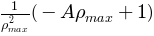

In [15]:
B_sol = sympy.solve(eq1,B)[0]
B_sol

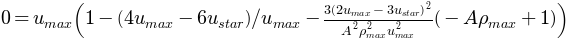

In [16]:
quadA = eq2.subs([(rho_star, rho_sol), (B,B_sol)])
quadA

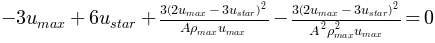

In [17]:
quadA.simplify()

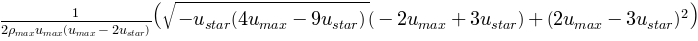

In [18]:
A_sol = sympy.solve(quadA, A)
A_sol[0]

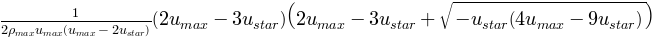

In [19]:
A_sol[1]

In [22]:
# negative root
A_sol[0].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})

In [24]:
# positive root
aval = A_sol[1].evalf(subs={u_star: 0.7, u_max: 1.0, rho_max: 10.0})
aval

In [26]:
bval = B_sol.evalf(subs={rho_max:10.0, A:aval})
bval

In [27]:
# turning off latax
sympy.init_printing(use_latex=False)

### Green light: take 2
check on rho_max and u_max typing:

In [28]:
print(type(rho_max), type(u_max))

<class 'sympy.core.symbol.Symbol'> <class 'sympy.core.symbol.Symbol'>


In [29]:
# re-define them as float to make numpy happy
rho_max = 10.
u_max = 1.

In [43]:
# functions
# compute flux
def computeF(u_max, rho, aval, bval):
    return u_max*rho*(1 - aval*rho - bval*rho**2)

# initial condition
def rho_green_light(nx, rho_light):
    
    rho_initial = numpy.arange(nx)*2./nx*rho_light # before stoplight
    rho_initial[int((nx-1)/2):] = 0                # after stoplight
    return rho_initial

# forward time/backward space scheme
def ftbs(rho,nt,dt,dx,rho_max,u_max):
    # initialize our results array with dimensionos nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    
    #copy initial u array into each row of our new array
    rho_n[0,:] = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max,rho,aval,bval)
        rho_n[t,1:] = rho[1:] - dt/dx*(F[1:]-F[:-1])
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
    return rho_n

In [34]:
import numpy
from matplotlib import pyplot, rcParams
%matplotlib inline
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [36]:
# initial condition paramters
# grid size, time steps
nx = 81
nt = 30
dx = 4.0/(nx-1)

x = numpy.linspace(0,4,nx)

rho_light = 5.5

In [37]:
rho_initial = rho_green_light(nx, rho_light)

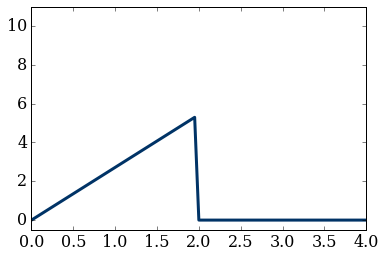

In [39]:
pyplot.plot(x, rho_initial, color='#003366', ls='-', lw=3)
pyplot.ylim(-0.5,11.);

In [44]:
sigma = 1.
dt = sigma*dx/u_max

rho_n = ftbs(rho_initial,nt,dt,dx,rho_max,u_max)

In [45]:
from matplotlib import animation
from IPython.display import HTML

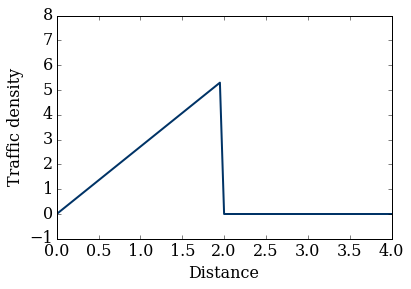

In [47]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(-1,8),xlabel='Distance',ylabel='Traffic density');
line, = ax.plot([],[],color='#003366', lw=2);

def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)

In [49]:
HTML(anim.to_html5_video())

### Dig Deeper:
Try to implement the green-light problem using a 2nd order shceme from lesson 2.

In [74]:
# second order functions:
# Jacobian function needed to be altered for new flux function
def Jacobian(u_max, rho, aval, bval):
    return u_max*(1-2*aval*rho-3*bval*rho**2)

# Lax-Wendroff function
# had to alter input for flux function computeF
def laxwendroff(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Wendroff scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    # initialize results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))
    # copy initial rho array into each row of new array
    rho_n[:,:] = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho, aval, bval)
        J = Jacobian(u_max, rho, aval, bval)
        
        rho_n[t,1:-1] = rho[1:-1] - dt/(2*dx)*(F[2:]-F[:-2]) \
                            + dt**2/(4*dx**2) * ( (J[2:]+J[1:-1])*(F[2:]-F[1:-1]) \
                            - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2]) )
            
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
    return rho_n

# MacCormack scheme
# # had to alter input for flux function computeF
def maccormack(rho, nt, dt, dx, u_max, rho_max):
    """ Computes the solution with MacCormack scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    rho_n = numpy.zeros((nt,len(rho)))
    rho_star = numpy.empty_like(rho)
    rho_n[:,:] = rho.copy()
    rho_star = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho, aval, bval)
        rho_star[:-1] = rho[:-1] - dt/dx*(F[1:]-F[:-1])
        Fstar = computeF(u_max, rho_star, aval, bval)
        rho_n[t,1:] = 0.5*(rho[1:]+rho_star[1:] - dt/dx*(Fstar[1:] - Fstar[:-1]))
        rho = rho_n[t].copy()
    return rho_n

### Lax-Wendroff scheme:

In [85]:
sigma = 0.5
dt = sigma*dx/u_max

rho_n_lax_wen = laxwendroff(rho_initial,nt,dt,dx,rho_max,u_max)

In [86]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n_lax_wen, interval=50)
HTML(anim.to_html5_video())

Didn't work out too well

### MacCormack scheme:

In [87]:
sigma = 0.5
dt = sigma*dx/u_max

rho_n_mac = maccormack(rho_initial,nt,dt,dx,rho_max,u_max)

G:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: overflow encountered in square


In [88]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n_mac, interval=50)
HTML(anim.to_html5_video())

Worked out even less.